In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import ast
import warnings
warnings.filterwarnings('ignore')



In [2]:
def load_data():
    """Charge les données"""
    df = pd.read_csv("../data/RAW_recipes.csv")
    return df

In [3]:

def prepare_text_data(df):
    """Prépare les données textuelles pour l'analyse"""
    
    print("\n" + "="*60)
    print("PRÉPARATION DES DONNÉES TEXTUELLES")
    print("="*60)
    
    # Combiner tags + name pour créer un document par recette
    df_clean = df[df['tags'].notna() & df['name'].notna()].copy()
    
    documents = []
    valid_indices = []
    
    for idx, row in df_clean.iterrows():
        try:
            # Extraire les tags
            tags = ast.literal_eval(row['tags'])
            # Combiner tags + nom (optionnel : + description)
            doc = ' '.join(tags) + ' ' + row['name'].lower()
            documents.append(doc)
            valid_indices.append(idx)
        except:
            continue
    
    print(f"\n Statistiques:")
    print(f"  Recettes totales: {len(df):,}")
    print(f"  Documents créés: {len(documents):,}")
    print(f"\n Exemple de document:")
    print(f"  {documents[0][:200]}...")
    
    # Retourner le bon subset du dataframe
    return documents, df_clean.loc[valid_indices].reset_index(drop=True)

In [4]:
def analyze_with_lda(documents, n_topics=10, n_top_words=15):
    """Analyse LDA (Latent Dirichlet Allocation)"""
    
    print("\n" + "="*60)
    print(f"ANALYSE LDA - {n_topics} TOPICS")
    print("="*60)
    
    # Vectorisation avec CountVectorizer (LDA nécessite des counts, pas TF-IDF)
    print("\n Vectorisation des documents...")
    vectorizer = CountVectorizer(
        max_features=5000,      # Top 5000 mots
        min_df=5,               # Mot présent dans au moins 5 documents
        max_df=0.7,             # Mot présent dans max 70% des documents
        stop_words='english',   # Retirer les stop words anglais
        ngram_range=(1, 2)      # Unigrammes et bigrammes
    )
    
    doc_term_matrix = vectorizer.fit_transform(documents)
    
    print(f"  Matrice créée: {doc_term_matrix.shape[0]:,} documents × {doc_term_matrix.shape[1]:,} mots")
    
    # LDA
    print(f"\n Entraînement du modèle LDA ({n_topics} topics)...")
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20,
        learning_method='online',
        n_jobs=-1
    )
    
    lda_topics = lda_model.fit_transform(doc_term_matrix)
    
    # Extraire les mots-clés par topic
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"\n TOPICS DÉCOUVERTS:\n")
    
    topic_keywords = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topic_keywords.append(top_words)
        
        print(f"Topic {topic_idx + 1}:")
        print(f"  Mots-clés: {', '.join(top_words)}")
        print()
    
    return lda_model, lda_topics, vectorizer, topic_keywords

In [6]:





def name_topics_manually(topic_keywords, vectorizer, lda_model):
    """Nommer intelligemment les topics basés sur les mots-clés"""
    
    print("\n" + "="*60)
    print("INTERPRÉTATION DES TOPICS")
    print("="*60)
    
    topic_names = []
    
    for idx, keywords in enumerate(topic_keywords):
        # Convertir en string pour analyse
        keywords_str = ' '.join(keywords[:10]).lower()
        
        # Score de confiance pour chaque catégorie
        scores = {}
        
        # Desserts & Sucreries
        dessert_words = ['chocolate', 'cake', 'cookie', 'dessert', 'sweet', 'pie', 
                        'sugar', 'frosting', 'candy', 'brownie', 'cupcake', 'ice cream',
                        'pudding', 'mousse', 'tart', 'cheesecake']
        scores[' Desserts & Pâtisseries'] = sum(1 for w in dessert_words if w in keywords_str)
        
        # Viandes
        meat_words = ['chicken', 'beef', 'pork', 'meat', 'steak', 'turkey', 
                     'lamb', 'bacon', 'sausage', 'ribs', 'roast', 'grilled']
        scores[' Plats de Viande'] = sum(1 for w in meat_words if w in keywords_str)
        
        # Légumes & Salades
        veggie_words = ['salad', 'vegetable', 'veggie', 'lettuce', 'tomato', 
                       'cucumber', 'green', 'fresh', 'healthy', 'vegan', 'vegetarian',
                       'avocado', 'spinach', 'kale']
        scores[' Salades & Légumes'] = sum(1 for w in veggie_words if w in keywords_str)
        
        # Cuisine Italienne
        italian_words = ['pasta', 'italian', 'spaghetti', 'lasagna', 'pizza', 
                        'parmesan', 'basil', 'marinara', 'penne', 'fettuccine',
                        'risotto', 'ravioli', 'pesto']
        scores[' Cuisine Italienne'] = sum(1 for w in italian_words if w in keywords_str)
        
        # Cuisine Mexicaine
        mexican_words = ['mexican', 'taco', 'burrito', 'salsa', 'tortilla', 
                        'enchilada', 'guacamole', 'chili', 'spicy', 'tex mex',
                        'quesadilla', 'nacho', 'jalapeno']
        scores[' Cuisine Mexicaine'] = sum(1 for w in mexican_words if w in keywords_str)
        
        # Pains & Boulangerie
        bread_words = ['bread', 'bake', 'dough', 'roll', 'muffin', 'scone', 
                      'yeast', 'flour', 'biscuit', 'bagel', 'croissant', 'loaf']
        scores[' Pains & Viennoiseries'] = sum(1 for w in bread_words if w in keywords_str)
        
        # Soupes & Ragoûts
        soup_words = ['soup', 'stew', 'broth', 'chowder', 'bisque', 'stock', 
                     'slow cooker', 'crockpot', 'simmer', 'casserole']
        scores[' Soupes & Ragoûts'] = sum(1 for w in soup_words if w in keywords_str)
        
        # Petit-déjeuner
        breakfast_words = ['breakfast', 'egg', 'pancake', 'waffle', 'omelet', 
                          'cereal', 'morning', 'brunch', 'french toast', 'oatmeal']
        scores[' Petit-déjeuner'] = sum(1 for w in breakfast_words if w in keywords_str)
        
        # Cuisine Asiatique
        asian_words = ['asian', 'chinese', 'thai', 'japanese', 'korean', 'rice', 
                      'soy sauce', 'ginger', 'sesame', 'wok', 'stir fry', 'noodle',
                      'teriyaki', 'curry', 'vietnamese']
        scores[' Cuisine Asiatique'] = sum(1 for w in asian_words if w in keywords_str)
        
        # Boissons
        drink_words = ['drink', 'beverage', 'cocktail', 'smoothie', 'juice', 
                      'coffee', 'tea', 'punch', 'shake', 'lemonade']
        scores[' Boissons'] = sum(1 for w in drink_words if w in keywords_str)
        
        # Fruits
        fruit_words = ['fruit', 'berry', 'apple', 'banana', 'strawberry', 
                      'orange', 'lemon', 'peach', 'cherry', 'blueberry', 'mango']
        scores[' Fruits & Compotes'] = sum(1 for w in fruit_words if w in keywords_str)
        
        # Grillades & BBQ
        grill_words = ['grill', 'bbq', 'barbecue', 'smoke', 'outdoor', 'marinade',
                      'charcoal', 'flame']
        scores[' Grillades & BBQ'] = sum(1 for w in grill_words if w in keywords_str)
        
        # Apéritifs & Snacks
        snack_words = ['appetizer', 'snack', 'finger food', 'party', 'dip', 
                      'chip', 'cracker', 'bite', 'canape']
        scores[' Apéritifs & Snacks'] = sum(1 for w in snack_words if w in keywords_str)
        
        # Poissons & Fruits de mer
        seafood_words = ['fish', 'seafood', 'salmon', 'tuna', 'shrimp', 'crab', 
                        'lobster', 'tilapia', 'cod', 'shellfish', 'prawn', 'oyster']
        scores[' Poissons & Fruits de mer'] = sum(1 for w in seafood_words if w in keywords_str)
        
        # Sauces & Condiments
        sauce_words = ['sauce', 'gravy', 'condiment', 'dressing', 'marinade', 
                      'vinaigrette', 'mayo', 'ketchup', 'mustard']
        scores[' Sauces & Condiments'] = sum(1 for w in sauce_words if w in keywords_str)
        
        # Trouver la catégorie avec le score le plus élevé
        if max(scores.values()) > 0:
            best_category = max(scores, key=scores.get)
            confidence = max(scores.values())
        else:
            # Si aucun match, utiliser les 3 premiers mots-clés
            best_category = f" {keywords[0].capitalize()} / {keywords[1].capitalize()} / {keywords[2].capitalize()}"
            confidence = 0
        
        topic_names.append(best_category)
        
        print(f"\nTopic {idx + 1} → {best_category}")
        print(f"  Confiance: {confidence}/15")
        print(f"  Mots-clés: {', '.join(keywords[:10])}")
    
    # Détecter les doublons et les renommer
    name_counts = {}
    final_names = []
    
    for name in topic_names:
        if name in name_counts:
            name_counts[name] += 1
            # Ajouter un numéro pour différencier
            final_names.append(f"{name} (Variante {name_counts[name]})")
        else:
            name_counts[name] = 1
            final_names.append(name)
    
    return final_names



In [7]:
def visualize_topics(lda_model, lda_topics, topic_names, df_sample, vectorizer, topic_keywords):
    """Visualisation des topics"""
    
    print("\n" + "="*60)
    print("VISUALISATION DES TOPICS")
    print("="*60)
    
    n_topics = lda_model.n_components
    
    # 1. Distribution des documents par topic dominant
    dominant_topics = np.argmax(lda_topics, axis=1)
    topic_counts = pd.Series(dominant_topics).value_counts().sort_index()
    
    print(f"\n Distribution des recettes par topic:")
    for topic_idx, count in topic_counts.items():
        pct = count / len(dominant_topics) * 100
        print(f"  {topic_names[topic_idx]:50s} : {count:6,} recettes ({pct:5.1f}%)")
    
    # Visualisations
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Bar chart de la distribution (TRIÉ PAR FRÉQUENCE)
    ax1 = plt.subplot(2, 2, 1)
    colors = plt.cm.Set3(np.linspace(0, 1, n_topics))
    
    # Trier par fréquence décroissante
    sorted_indices = topic_counts.sort_values(ascending=True).index
    sorted_names = [topic_names[i] for i in sorted_indices]
    sorted_counts = [topic_counts.get(i, 0) for i in sorted_indices]
    sorted_colors = [colors[i] for i in sorted_indices]
    
    bars = ax1.barh(range(len(sorted_indices)), sorted_counts,
                     color=sorted_colors, edgecolor='black', alpha=0.8)
    ax1.set_yticks(range(len(sorted_indices)))
    ax1.set_yticklabels(sorted_names, fontsize=9)
    ax1.set_xlabel('Nombre de recettes', fontsize=12)
    ax1.set_title('Distribution des recettes par topic (triée)', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Annoter les barres
    for i, (bar, count) in enumerate(zip(bars, sorted_counts)):
        if count > 0:
            ax1.text(count + 500, bar.get_y() + bar.get_height()/2, 
                    f'{int(count):,}', va='center', fontsize=8)
    
    # 2. Pie chart avec pourcentages
    ax2 = plt.subplot(2, 2, 2)
    
    # Utiliser les noms courts pour le pie chart
    short_names = []
    for name in topic_names:
        # Extraire seulement l'emoji et le premier mot
        if '&' in name:
            short_name = name.split('&')[0].strip()
        elif '/' in name:
            short_name = name.split('/')[0].strip()
        else:
            short_name = name[:25]
        short_names.append(short_name)
    
    explode = [0.05] * n_topics
    wedges, texts, autotexts = ax2.pie(
        [topic_counts.get(i, 0) for i in range(n_topics)],
        labels=None,  # Pas de labels sur le pie
        autopct='%1.1f%%', 
        colors=colors, 
        explode=explode,
        startangle=90, 
        textprops={'fontsize': 9, 'fontweight': 'bold'}
    )
    
    # Légende à côté
    ax2.legend(wedges, short_names, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=8)
    ax2.set_title('Répartition en pourcentage', fontsize=14, fontweight='bold')
    
    # 3. Heatmap des mots par topic (top 10 mots)
    ax3 = plt.subplot(2, 1, 2)
    
    # Créer une matrice : topics × mots
    top_n_words = 10
    word_topic_matrix = np.zeros((n_topics, top_n_words))
    
    # Récupérer les vrais noms de features
    feature_names = vectorizer.get_feature_names_out()
    word_labels = []
    
    # Pour chaque topic, extraire les poids des top mots
    for topic_idx in range(n_topics):
        topic_weights = lda_model.components_[topic_idx]
        top_indices = topic_weights.argsort()[-top_n_words:][::-1]
        word_topic_matrix[topic_idx] = topic_weights[top_indices]
        
        if topic_idx == 0:
            word_labels = [feature_names[i] for i in top_indices]
    
    sns.heatmap(word_topic_matrix, 
                xticklabels=word_labels,
                yticklabels=[f"T{i+1}" for i in range(n_topics)],
                cmap='YlOrRd', annot=False, fmt='.2f',
                cbar_kws={'label': 'Poids du mot'},
                ax=ax3)
    
    ax3.set_title('Importance des mots-clés par topic', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Mots-clés', fontsize=12)
    ax3.set_ylabel('Topics', fontsize=12)
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    
    plt.tight_layout()
   
    plt.show()



In [8]:
def analyze_topic_trends(lda_topics, df_sample, topic_names):
    """Analyse des tendances temporelles des topics"""
    
    print("\n" + "="*60)
    print("ANALYSE TEMPORELLE DES TOPICS")
    print("="*60)
    
    # Ajouter la date
    df_sample = df_sample.copy()
    df_sample['date'] = pd.to_datetime(df_sample['submitted'], errors='coerce')
    df_sample['year'] = df_sample['date'].dt.year
    df_sample['dominant_topic'] = np.argmax(lda_topics, axis=1)
    
    # Filtrer les années valides
    df_valid = df_sample[df_sample['year'].notna()].copy()
    
    if len(df_valid) == 0:
        print("  Pas de données temporelles disponibles")
        return
    
    # Evolution par année
    topic_by_year = df_valid.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)
    
    print(f"\n Topics les plus populaires par période:")
    years_range = [2008, 2012, 2016]
    for year in years_range:
        if year in topic_by_year.index:
            top_topic = topic_by_year.loc[year].idxmax()
            count = topic_by_year.loc[year, top_topic]
            print(f"  {year}: {topic_names[top_topic]} ({count:,} recettes)")
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Ligne par topic
    for topic_idx in range(len(topic_names)):
        if topic_idx in topic_by_year.columns:
            ax.plot(topic_by_year.index, topic_by_year[topic_idx], 
                   marker='o', linewidth=2, label=topic_names[topic_idx], alpha=0.7)
    
    ax.set_xlabel('Année', fontsize=12)
    ax.set_ylabel('Nombre de recettes', fontsize=12)
    ax.set_title('Évolution temporelle des topics culinaires', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
  
    plt.show()



 Chargement des données...
 231,637 recettes chargées


PRÉPARATION DES DONNÉES TEXTUELLES

 Statistiques:
  Recettes totales: 231,637
  Documents créés: 231,636

 Exemple de document:
  60-minutes-or-less time-to-make course main-ingredient cuisine preparation occasion north-american side-dishes vegetables mexican easy fall holiday-event vegetarian winter dietary christmas seasonal s...

ANALYSE LDA - 10 TOPICS

 Vectorisation des documents...
  Matrice créée: 231,636 documents × 5,000 mots

 Entraînement du modèle LDA (10 topics)...

 TOPICS DÉCOUVERTS:

Topic 1:
  Mots-clés: taste, mood, taste mood, beginner, beginner cook, occasion, preparation occasion, cook, easy beginner, food, comfort, comfort food, easy, inexpensive, mood equipment

Topic 2:
  Mots-clés: low, healthy, dietary low, fat, sodium, low sodium, cholesterol, low cholesterol, protein, calorie, low calorie, carb, low carb, sodium low, low protein

Topic 3:
  Mots-clés: eggs, vegetables, course main, dairy, eggs dairy, 

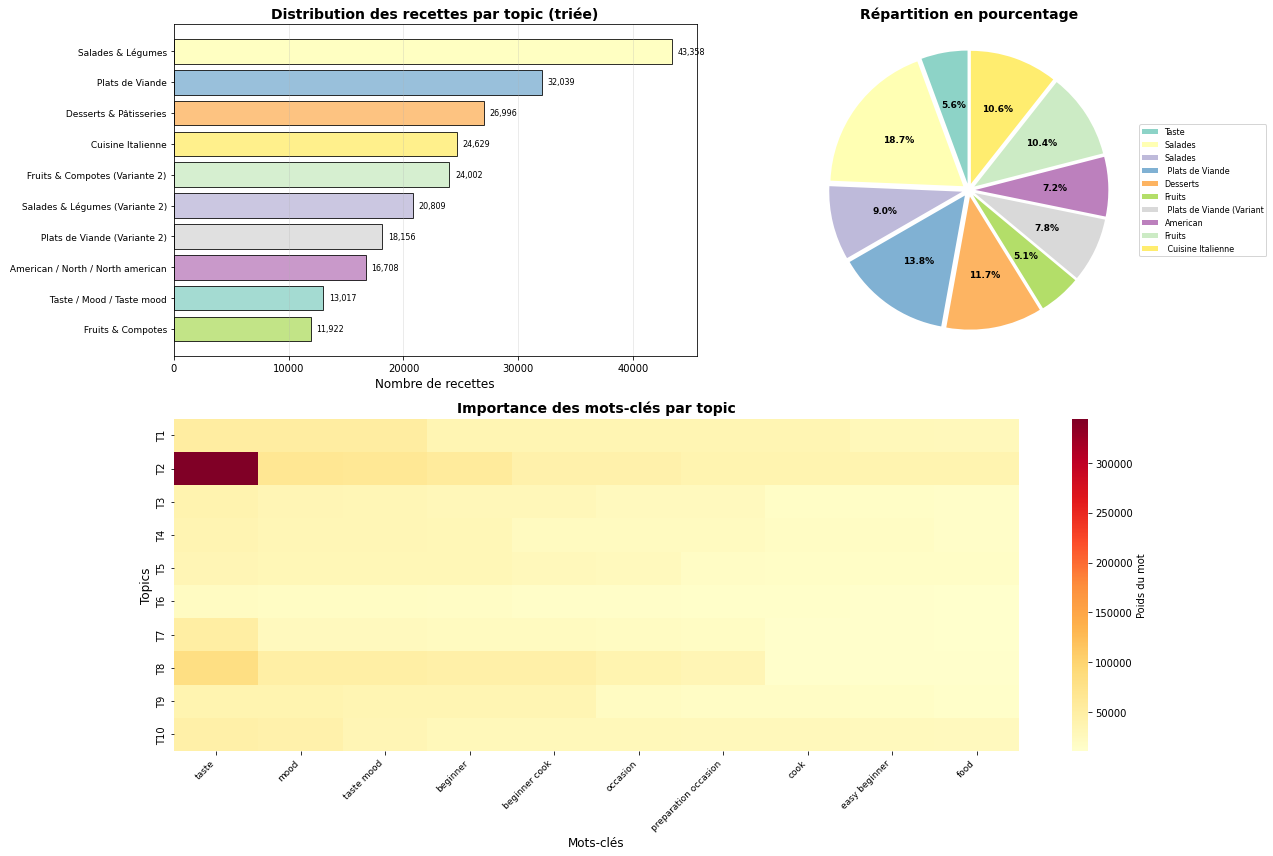


ANALYSE TEMPORELLE DES TOPICS

 Topics les plus populaires par période:
  2008:  Salades & Légumes (5,866 recettes)
  2012:  Salades & Légumes (1,055 recettes)
  2016:  Desserts & Pâtisseries (52 recettes)


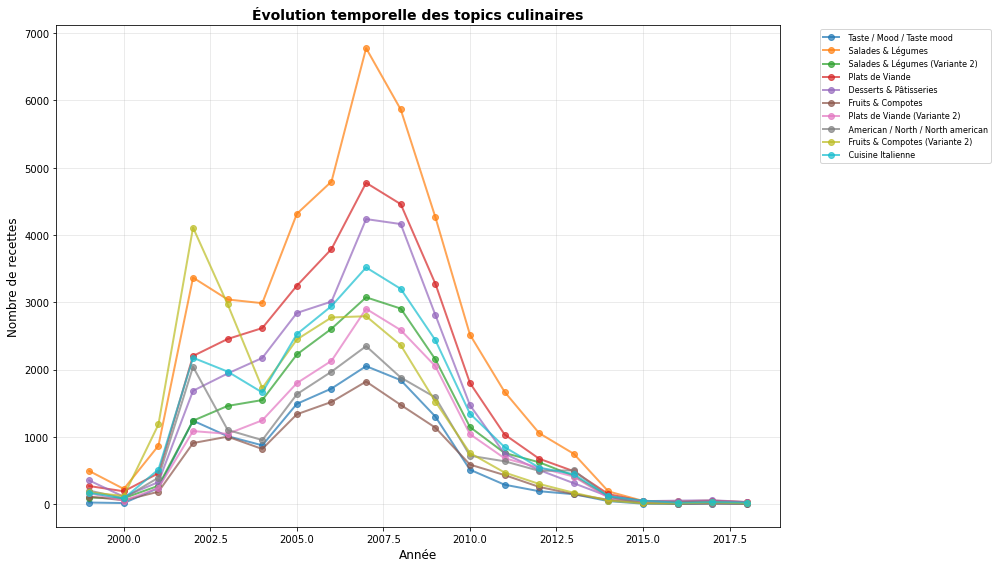

In [9]:
def main():
    """Fonction principale"""
    
    print(" Chargement des données...")
    df = load_data()
    print(f" {len(df):,} recettes chargées\n")
    
    # 1. Préparation
    documents, df_sample = prepare_text_data(df)
    
    # 2. LDA
    lda_model, lda_topics, vectorizer, topic_keywords = analyze_with_lda(
        documents, 
        n_topics=10,
        n_top_words=15
    )
    
    # 3. Nommer les topics
    topic_names = name_topics_manually(topic_keywords, vectorizer, lda_model)
    
    # 4. Visualisations
    visualize_topics(lda_model, lda_topics, topic_names, df_sample, vectorizer, topic_keywords)
    
    # 5. Tendances temporelles
    analyze_topic_trends(lda_topics, df_sample, topic_names)
    

   

if __name__ == "__main__":
    main()